In [1]:
!nvidia-smi

Sun Nov  3 18:44:32 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import numpy as np
import regex as re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import math
import os

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
import tokenizers
from transformers import RobertaTokenizer, TFRobertaModel

from collections import Counter

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Detect hardware, return appropriate distribution strategy (you can see that it is pretty easy to set up).
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set (always set in Kaggle)
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [4]:
MODEL_NAME = 'roberta-base'
MAX_LEN = 256
ARTIFACTS_PATH = '../artifacts/'

BATCH_SIZE = 8 * strategy.num_replicas_in_sync
EPOCHS = 10

if not os.path.exists(ARTIFACTS_PATH):
    os.makedirs(ARTIFACTS_PATH)

# **DATA PREPARATION**

In [5]:
import pandas as pd

# Load the Excel file
file_path = '/kaggle/input/mentidata/mentidata.xlsx'

# Load Sheet 6
df = pd.read_excel(file_path, sheet_name='Sheet 6 - forum', engine='openpyxl')
df.columns = ['PA', 'IVA', 'SA', 'SEA']
print(df.columns)
df = df.drop(index=0).reset_index(drop=True)
df.head()

Index(['PA', 'IVA', 'SA', 'SEA'], dtype='object')


,PA,IVA,SA,SEA
0,NaN,“My dad has been depressed fir as long as i ca...,NaN,"""It feels like his depression has skyrocketed ..."
1,NaN,NaN,NaN,"“It feels like everything I do is futile, and ..."
2,NaN,NaN,“My mum and dad have cut me off and it's been ...,“That part of my heart has been left empty and...
3,NaN,NaN,NaN,“now I feel more depressed than ever feel alon...
4,“I have also gained so much weight in the last...,NaN,“I have no social interactions as I feel unwor...,“I have no motivation I am crying all the time...


In [6]:
data = []

import re  # Importing the regular expressions module
# Iterate over each row
for index, row in df.iterrows(): 
    for category in df.columns:
        text_data = row[category]
        if pd.notna(text_data) and text_data != '':
            text_data = text_data.replace('“', '"').replace('”', '"')
            # Split the text data by double quotes and strip whitespace
            texts = [text.strip() for text in text_data.split('"') if text.strip()]
#             texts = [text.strip() for text in re.split(r'["\”]', text_data) if text.strip()]
            for text in texts: 
                data.append([text, category])  # Append each text and its category


# Create a new DataFrame
new_df = pd.DataFrame(data, columns=['Text', 'Category'])

# Display the new DataFrame
import IPython.display as display
display.display(new_df)

,Text,Category
0,My dad has been depressed fir as long as i can...,IVA
1,It feels like his depression has skyrocketed t...,SEA
2,he is 60 years old but im only 19 and have my ...,SEA
3,ive been having nightmares and i really just d...,SEA
4,"It feels like everything I do is futile, and a...",SEA
...,...,...
1593,I feel guilty for my depression,SEA
1594,Life was great. until about 4 weeks ago the lo...,SA
1595,I’m already in so much pain I don’t know if my...,SEA
1596,I’ve been doing a lot of trauma recovery work ...,PA


In [7]:
new_df['Text'] = new_df['Text'].apply(lambda x:x.lower())

from nltk.corpus import stopwords

sw_list = stopwords.words('english')

new_df['Text'] = new_df['Text'].apply(lambda x: [item for item in x.split() if item not in sw_list]).apply(lambda x:" ".join(x))

In [8]:
X_data = new_df[['Text']].to_numpy().reshape(-1)
y_data = new_df[['Category']].to_numpy().reshape(-1)

# **DATASET ANALYSIS**

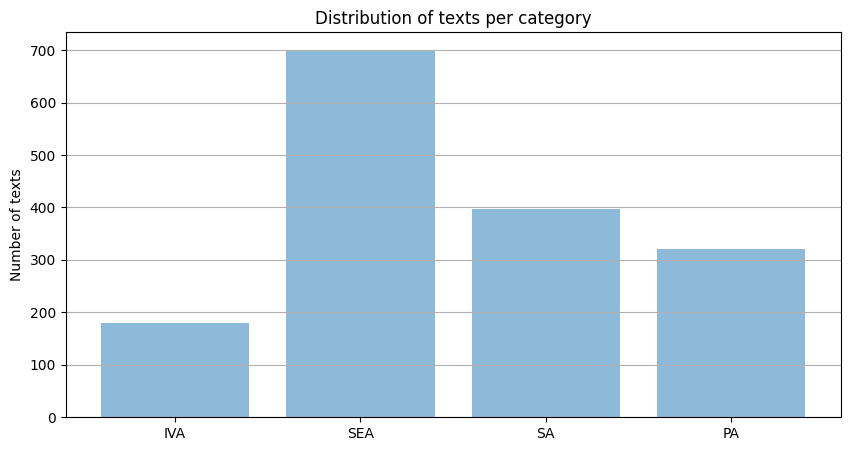

Counter({'SEA': 699, 'SA': 398, 'PA': 321, 'IVA': 180})


In [9]:
categories = new_df[['Category']].values.reshape(-1)

counter_categories = Counter(categories)
category_names = counter_categories.keys()
category_values = counter_categories.values()

y_pos = np.arange(len(category_names))

plt.figure(1, figsize=(10, 5))
plt.bar(y_pos, category_values, align='center', alpha=0.5)
plt.xticks(y_pos, category_names)
plt.ylabel('Number of texts')
plt.title('Distribution of texts per category')
plt.gca().yaxis.grid(True)
plt.show()

print(counter_categories)

In [10]:
def calculate_stats(df, split_char=' '):
    categories = df['Category'].unique()
    
    all_lengths = []
    per_category = {
        'lengths': {c:[] for c in categories},
        'mean': {c:0 for c in categories},
        'stdev': {c:0 for c in categories}
    }

    for index, row in df.iterrows():
        text = row['Text']
        text = re.sub(r"\s+", ' ', text) # Normalize
        text = text.split(split_char)
        l = len(text)
        
        category = row['Category']
        
        all_lengths.append(l)
        per_category['lengths'][category].append(l)
    
    for c in categories:
        per_category['mean'][c] = statistics.mean(per_category['lengths'][c])
        per_category['stdev'][c] = statistics.stdev(per_category['lengths'][c])
    
    global_stats = {
        'mean': statistics.mean(all_lengths),
        'stdev': statistics.stdev(all_lengths),
        'lengths': all_lengths
    }
    
    return {
        'global': global_stats,
        'per_category': pd.DataFrame(per_category)
    }

In [11]:
def display_lengths_histograms(df_stats, n_cols=3):
    categories = new_df['Category'].unique()
    n_rows = math.ceil(len(categories) / n_cols)
    
    plt.figure(figsize=(15, 8))
    plt.suptitle('Distribution of lengths')
    
    # Subplot of all lengths
    plt.subplot(n_rows, n_cols, 1)
    plt.title('All categories')
    lengths = df_stats['global']['lengths']
    plt.hist(lengths, color='r')

    # Subplot of each category
    index_subplot = 2
    for c in categories:
        plt.subplot(n_rows, n_cols, index_subplot)
        plt.title('Category: %s' % c)
        
        lengths = df_stats['per_category']['lengths'][c]
        plt.hist(lengths, color='b')

        index_subplot += 1

    plt.show()

In [12]:
df_stats = calculate_stats(new_df)
df_stats['per_category']

,lengths,mean,stdev
IVA,"[12, 10, 6, 13, 5, 20, 9, 8, 8, 9, 3, 6, 10, 2...",13.611111,7.949835
SEA,"[11, 13, 13, 13, 11, 10, 18, 12, 9, 10, 6, 11,...",10.346209,5.610599
SA,"[23, 12, 6, 8, 4, 6, 5, 18, 9, 9, 3, 13, 6, 10...",13.472362,7.311906
PA,"[9, 7, 27, 14, 9, 11, 7, 6, 6, 7, 9, 9, 10, 9,...",12.221184,7.123310


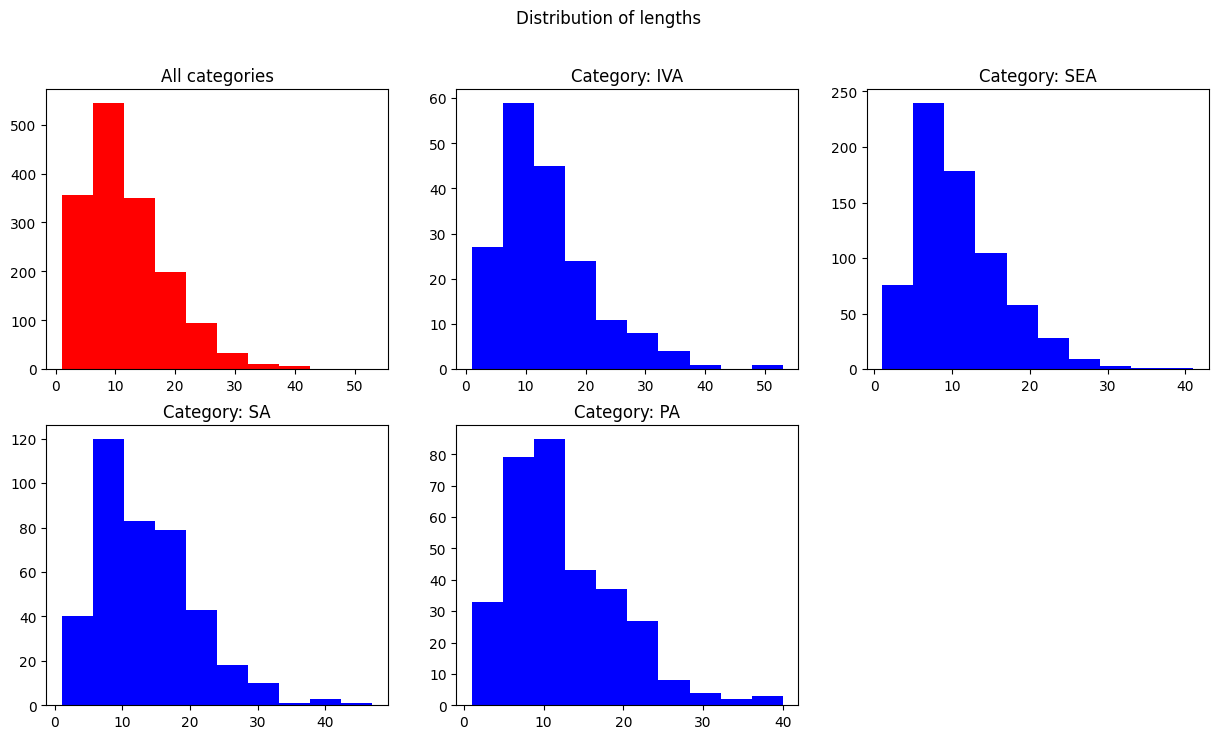

In [13]:
display_lengths_histograms(df_stats)

In [14]:
n_texts = len(X_data)
print('Texts in dataset: %d' % n_texts)

categories = new_df['Category'].unique()
n_categories = len(categories)
print('Number of categories: %d' % n_categories)

print('Done!')

Texts in dataset: 1598
Number of categories: 4
Done!


# **TOKENIZE AND ENCODE**

In [15]:
def roberta_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32') # Not used in text classification

    for k, text in enumerate(texts):
        # Tokenize
        tok_text = tokenizer.tokenize(text)
        
        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])
        
        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN
        
        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')
        
        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }

In [16]:
# Transform categories into numbers
category_to_id = {}
category_to_name = {}

for index, c in enumerate(y_data):
    if c in category_to_id:
        category_id = category_to_id[c]
    else:
        category_id = len(category_to_id)
        category_to_id[c] = category_id
        category_to_name[category_id] = c
    
    y_data[index] = category_id

# Display dictionary
category_to_name

{0: 'IVA', 1: 'SEA', 2: 'SA', 3: 'PA'}

In [17]:
# Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=777) # random_state to reproduce results

In [18]:
# Import tokenizer from HuggingFace
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [19]:
X_train = roberta_encode(X_train, tokenizer)
X_test = roberta_encode(X_test, tokenizer)

y_train = np.asarray(y_train, dtype='int32')
y_test = np.asarray(y_test, dtype='int32')

# **CREATING RoBERTa MODEL**

In [20]:
def build_model(n_categories):
    input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
    input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')

    # Import RoBERTa model from HuggingFace
    roberta_model = TFRobertaModel.from_pretrained(MODEL_NAME)
    
    # Wrap the RoBERTa model call inside a Lambda layer and specify the output shape
    def roberta_embedding(inputs):
        ids, mask = inputs
        return roberta_model(ids, attention_mask=mask)[0]

    x = tf.keras.layers.Lambda(roberta_embedding, output_shape=(MAX_LEN, 768))([input_word_ids, input_mask])

    x = tf.keras.layers.Dropout(0.5)(x) 
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dense(n_categories, activation='softmax')(x)

    model = tf.keras.Model(inputs=[input_word_ids, input_mask], outputs=x)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [21]:
with strategy.scope():
    model = build_model(n_categories)
    model.summary()

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_word_ids      │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_mask          │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 256, 768)  │          0 │ input_word_ids[0… │
│                     │                   │            │ input_mask[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 768)  │          0 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 196608)    │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │ 50,331,904 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4)         │      1,028 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 50,332,932 (192.00 MB)

 Trainable params: 50,332,932 (192.00 MB)

 Non-trainable params: 0 (0.00 B)

# **MODEL TRAINING**

In [22]:
with strategy.scope():
    print('Training...')
    history = model.fit(X_train,
                        y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        verbose=1,
                        validation_data=(X_test, y_test))

Training...
Epoch 1/10


I0000 00:00:1730659516.330656      74 service.cc:145] XLA service 0x7e4a1c0192e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730659516.330717      74 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1730659516.330722      74 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1730659516.910449      74 assert_op.cc:38] Ignoring Assert operator functional_1_1/lambda_1/tf_roberta_model/roberta/embeddings/assert_less/Assert/Assert
I0000 00:00:1730659521.024039     108 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1730659525.241220     106 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1', 968 bytes spill stores, 924 bytes spill loads



  1/140 ━━━━━━━━━━━━━━━━━━━━ 57:40 25s/step - accuracy: 0.2500 - loss: 1.4183

I0000 00:00:1730659528.580911      74 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


139/140 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.4442 - loss: 1.2885

W0000 00:00:1730659543.172245      75 assert_op.cc:38] Ignoring Assert operator functional_1_1/lambda_1/tf_roberta_model/roberta/embeddings/assert_less/Assert/Assert
I0000 00:00:1730659546.703386     126 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1730659551.890708     127 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1', 968 bytes spill stores, 924 bytes spill loads



140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.4447 - loss: 1.2876

W0000 00:00:1730659556.873203      76 assert_op.cc:38] Ignoring Assert operator functional_1_1/lambda_1/tf_roberta_model/roberta/embeddings/assert_less/Assert/Assert


140/140 ━━━━━━━━━━━━━━━━━━━━ 61s 257ms/step - accuracy: 0.4451 - loss: 1.2866 - val_accuracy: 0.5750 - val_loss: 1.0586
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - accuracy: 0.6516 - loss: 0.8715 - val_accuracy: 0.6271 - val_loss: 0.9045
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 147ms/step - accuracy: 0.7000 - loss: 0.7899 - val_accuracy: 0.6417 - val_loss: 0.9006
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 150ms/step - accuracy: 0.7447 - loss: 0.6243 - val_accuracy: 0.6562 - val_loss: 0.8947
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - accuracy: 0.7975 - loss: 0.5432 - val_accuracy: 0.6667 - val_loss: 0.9168
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - accuracy: 0.8117 - loss: 0.4935 - val_accuracy: 0.6687 - val_loss: 0.9563
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - accuracy: 0.8067 - loss: 0.4783 - val_accuracy: 0.6083 - val_loss: 1.0521
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - accuracy: 0.8376 - loss: 0.4041 - val

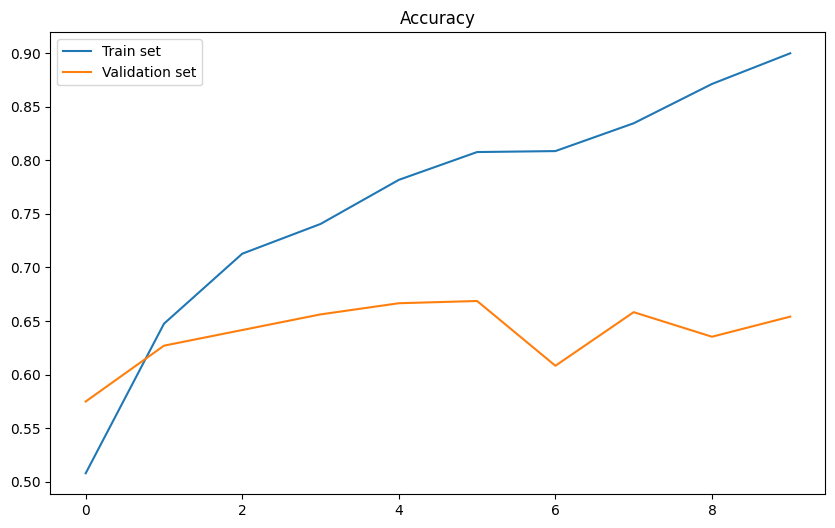

In [23]:
# This plot will look much better if we train models with more epochs, but anyway here is
plt.figure(figsize=(10, 6))
plt.title('Accuracy')

xaxis = np.arange(len(history.history['accuracy']))
plt.plot(xaxis, history.history['accuracy'], label='Train set')
plt.plot(xaxis, history.history['val_accuracy'], label='Validation set')
plt.legend()

# **EVALUATION**

In [24]:
def plot_confusion_matrix(X_test, y_test, model):
    y_pred = model.predict(X_test)
    y_pred = [np.argmax(i) for i in model.predict(X_test)]

    con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()

    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    label_names = list(range(len(con_mat_norm)))

    con_mat_df = pd.DataFrame(con_mat_norm,
                              index=label_names, 
                              columns=label_names)

    figure = plt.figure(figsize=(10, 6))
    sns.heatmap(con_mat_df, cmap=plt.cm.Blues, annot=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [25]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1] * 100))

W0000 00:00:1730659758.530295      74 assert_op.cc:38] Ignoring Assert operator functional_1_1/lambda_1/tf_roberta_model/roberta/embeddings/assert_less/Assert/Assert


Accuracy: 65.42%


In [26]:
from sklearn.metrics import classification_report

# Assuming `y_pred` are the model predictions for `X_test`
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)  # Convert predictions to class labels if they are probabilities

# Print the accuracy
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1] * 100))

# Print precision, recall, and F1-score for each class
print(classification_report(y_test, y_pred, digits=2))

scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1] * 100))

W0000 00:00:1730659769.774415      74 assert_op.cc:38] Ignoring Assert operator functional_1_1/lambda_1/tf_roberta_model/roberta/embeddings/assert_less/Assert/Assert


15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 391ms/step
Accuracy: 65.42%
              precision    recall  f1-score   support

           0       0.70      0.58      0.64        53
           1       0.67      0.66      0.66       203
           2       0.59      0.66      0.62       119
           3       0.70      0.68      0.69       105

    accuracy                           0.65       480
   macro avg       0.66      0.65      0.65       480
weighted avg       0.66      0.65      0.65       480

Accuracy: 65.42%


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 394ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 393ms/step


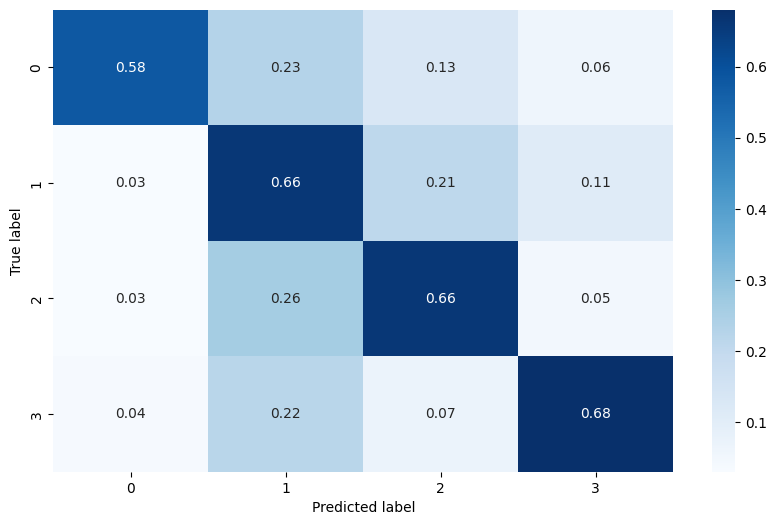

In [27]:
plot_confusion_matrix(X_test, y_test, model)

In [28]:
from transformers import RobertaTokenizer, TFRobertaModel
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = TFRobertaModel.from_pretrained('roberta-base')
text = "Replace me by any text you'd like."
encoded_input = tokenizer(text, return_tensors='tf')
output = model(encoded_input)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [29]:
encoded_input

{'input_ids': <tf.Tensor: shape=(1, 12), dtype=int32, numpy=
array([[   0, 9064, 6406,  162,   30,  143, 2788,   47, 1017,  101,    4,
           2]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 12), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}